In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms, models
import pandas as pd
import os
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
import cv2
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./data.csv', names=["id", "image", "published", "disabled"], header=None)

df['available'] = 0

all_images_path = 'data/all_images'

for i, row in df.iterrows():
    file = os.path.join(all_images_path, row['id'] + '.jpg')
    if os.path.isfile(file):
        df.at[i, 'available'] = 1
    

In [3]:
total_sample_per_class = 2000

published_df = df.loc[df.query('available == 1 and published == 1').index, :]
published_df = published_df.reset_index(drop=True).loc[:total_sample_per_class, :]
disabled_df = df.query('available == 1 and disabled == 1')
disabled_df = disabled_df.reset_index(drop=True).loc[:total_sample_per_class, :]


all_data_df = pd.concat([published_df, disabled_df], ignore_index=True)
all_data_df

,id,image,published,disabled,available
0,5e5836fee917e8d9a8a7b277,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
1,5e58343ded065ad79e312f3d,https://scontent.xx.fbcdn.net/v/t51.2885-15/85...,1,0,1
2,5e57dc939e88b6be2ac42800,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
3,5e55dca437fa5927dcdf02f3,https://scontent.xx.fbcdn.net/v/t51.2885-15/81...,1,0,1
4,5e55d69eb9e5b725cd7ba02f,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
...,...,...,...,...,...
3997,5e44a11be6d567a757263a1d,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
3998,5e44a11c5900fba75071d350,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
3999,5e44a11cac3b86a75e378f5d,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
4000,5e449ed2dbb087a5597e6826,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1


In [4]:


train_df, test_df = train_test_split(all_data_df, test_size=0.4, random_state=42)
validation_df, test_df = train_test_split(test_df, test_size=0.3, random_state=42)
print('train df {}, validation df {}, test df {}'.format(len(train_df),len(validation_df),len(test_df)))
print('train published {}, disabled {}'.format(
        len(train_df.loc[train_df['published'] == 1, :]),
        len(train_df.loc[train_df['disabled'] == 1, :])))
print('validation published {}, disabled {}'.format(
        len(validation_df.loc[validation_df['published'] == 1, :]),
        len(validation_df.loc[validation_df['disabled'] == 1, :])))

train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train df 2401, validation df 1120, test df 481
train published 1179, disabled 1222
validation published 577, disabled 543


In [5]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

Using 1 GPUs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

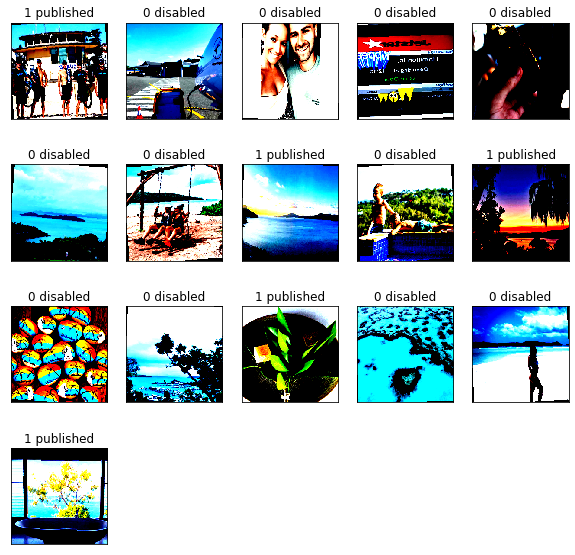

In [6]:
    
print(f"Using {torch.cuda.device_count()} GPUs")

torch.manual_seed(0)

# visualise data
def visualise_data(data_loader, classes):    
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    labels = labels.numpy()

    num_rows = 4
    num_cols = 5

    fig = plt.figure(figsize=(10, 10))
    for i in range(num_rows*num_cols):
        if i >= len(labels):
            break
        ax = fig.add_subplot(num_rows, num_cols, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        label = labels[i]
        ax.set_title(f"{label} {classes[label]}")

        
class MyDataset(Dataset):
    def __init__(self, data_df, all_images_path, transform=None):
        super().__init__()
        self.data_df = data_df
        self.transform = transform
        self.all_images_path = all_images_path
        
    def __getitem__(self, index):
        _id = self.data_df.loc[index, 'id']
        label = 0 if self.data_df.loc[index, 'disabled'] else 1
                
        file = os.path.join(self.all_images_path, _id + '.jpg')
        
        img = mpimg.imread(file)        
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
        
    def __len__(self):
        return len(self.data_df)

        
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    normalize
])        

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize    
])

# create Dataloader
batch_size = 16
all_images_path = 'data/all_images'

train_dataset = MyDataset(train_df, all_images_path, train_transform)
validation_dataset = MyDataset(validation_df, all_images_path, test_transform)
test_dataset = MyDataset(test_df, all_images_path, test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

classes = ['disabled', 'published']
visualise_data(train_dataloader, classes)

In [7]:
"""
dummy_data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)), 
    transforms.ToTensor(),
    normalize
])

dummy_train_dataset = torchvision.datasets.ImageFolder('dummy_data/flower_photos/train', transform=dummy_data_transform)
dummy_test_dataset = torchvision.datasets.ImageFolder('dummy_data/flower_photos/test', transform=dummy_data_transform)


dummy_train_loader = torch.utils.data.DataLoader(dummy_train_dataset, batch_size=32, shuffle=True)
dummy_test_loader = torch.utils.data.DataLoader(dummy_test_dataset, batch_size=32, shuffle=True)


dummy_classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
        
visualise_data(dummy_train_loader, dummy_classes)

"""



"\ndummy_data_transform = transforms.Compose([\n    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)), \n    transforms.ToTensor(),\n    normalize\n])\n\ndummy_train_dataset = torchvision.datasets.ImageFolder('dummy_data/flower_photos/train', transform=dummy_data_transform)\ndummy_test_dataset = torchvision.datasets.ImageFolder('dummy_data/flower_photos/test', transform=dummy_data_transform)\n\n\ndummy_train_loader = torch.utils.data.DataLoader(dummy_train_dataset, batch_size=32, shuffle=True)\ndummy_test_loader = torch.utils.data.DataLoader(dummy_test_dataset, batch_size=32, shuffle=True)\n\n\ndummy_classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']\n        \nvisualise_data(dummy_train_loader, dummy_classes)\n\n"

In [8]:
def get_model(classes):  
    num_output_classes = len(classes)
    pretrained_model = models.mobilenet_v2(pretrained=True)    
    in_feature = pretrained_model.classifier[-1].in_features
    pretrained_model.classifier[-1] = torch.nn.Linear(in_feature, num_output_classes)
    return pretrained_model

# test_model = get_model(classes)
# print(test_model)

In [9]:

def train_model(model, train_dataloader, val_dataloader, epochs, lr, checkpoint_file, early_stopping=5):
    criterion = torch.nn.CrossEntropyLoss() # soft max on cross entropy
    optimizer = torch.optim.SGD(model.classifier.parameters(), lr=lr)
    no_improvements = 0
    best_loss = np.inf
    train_losses = []
    val_losses = []
    
    # freeze the convolutional layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    if train_on_gpu:
        model = model.cuda()
        
    for epoch in range(epochs):        
        train_loss = 0
        val_loss = 0
    
        model.train()        
        for batch_i, (images, labels) in enumerate(train_dataloader):
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
                            
            optimizer.zero_grad()
            out = model(images)
            
            # out: (batch_size, num_classes) 
            # labels: (batch_size)
            loss = criterion(out, labels) 
            loss.backward()
            optimizer.step()            
            train_loss += loss.item()
                        
            if batch_i % 10 == 0:
                print("Epoch {}, batch {}, train loss {}".format(
                    epoch,
                    batch_i,
                    loss.item()/labels.size(0)
                ))
            
        # avg train loss
        train_loss = train_loss/len(train_dataloader.dataset)
                    
        model.eval()
        for images, labels in val_dataloader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            
            out = model(images)
            loss = criterion(out, labels)
            val_loss += loss.item()
            
        
        # avg val loss
        val_loss = val_loss/len(val_dataloader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('> Epoch {}, train loss {}, val loss {}'.format(epoch, train_loss, val_loss))
        
        
        if best_loss > val_loss:
            best_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), checkpoint_file)
            print('> Saving model')
        else:
            no_improvement += 1
            if no_improvement == early_stopping:
                print(f'> No Improvement for {early_stopping} epochs, Early Stopping')
                break    
                
        
    
    
# train on dummy to validation the network
pretrained_model = get_model(classes)



checkpointfile = 'models/not_finetune.pt'
epochs = 20
lr = .001
train_model(pretrained_model, train_dataloader, validation_dataloader, epochs, lr, checkpointfile)




Epoch 0, batch 0, train loss 0.043407004326581955
Epoch 0, batch 10, train loss 0.04278407618403435
Epoch 0, batch 20, train loss 0.04497876390814781
Epoch 0, batch 30, train loss 0.03732013702392578
Epoch 0, batch 40, train loss 0.043748557567596436
Epoch 0, batch 50, train loss 0.04608733206987381
Epoch 0, batch 60, train loss 0.05249025300145149
Epoch 0, batch 70, train loss 0.03691265732049942
Epoch 0, batch 80, train loss 0.04001707211136818
Epoch 0, batch 90, train loss 0.04463234171271324
Epoch 0, batch 100, train loss 0.04636233299970627
Epoch 0, batch 110, train loss 0.04216383025050163
Epoch 0, batch 120, train loss 0.044725462794303894
Epoch 0, batch 130, train loss 0.0430111400783062
Epoch 0, batch 140, train loss 0.04053846001625061
Epoch 0, batch 150, train loss 0.8076110482215881
> Epoch 0, train loss 0.04253939666732159, val loss 0.04018915857055357
> Saving model
Epoch 1, batch 0, train loss 0.04597785696387291
Epoch 1, batch 10, train loss 0.04049072414636612
Epoch 1,

Epoch 9, batch 50, train loss 0.036096617579460144
Epoch 9, batch 60, train loss 0.05251084640622139
Epoch 9, batch 70, train loss 0.03598656877875328
Epoch 9, batch 80, train loss 0.02721976675093174
Epoch 9, batch 90, train loss 0.036576323211193085
Epoch 9, batch 100, train loss 0.03418770059943199
Epoch 9, batch 110, train loss 0.028526239097118378
Epoch 9, batch 120, train loss 0.034481097012758255
Epoch 9, batch 130, train loss 0.03249063342809677
Epoch 9, batch 140, train loss 0.03452134132385254
Epoch 9, batch 150, train loss 0.7801799774169922
> Epoch 9, train loss 0.036102055473061515, val loss 0.03692338988184929
Epoch 10, batch 0, train loss 0.043519146740436554
Epoch 10, batch 10, train loss 0.03258596360683441
Epoch 10, batch 20, train loss 0.045624569058418274
Epoch 10, batch 30, train loss 0.031201636418700218
Epoch 10, batch 40, train loss 0.024571338668465614
Epoch 10, batch 50, train loss 0.03320572152733803
Epoch 10, batch 60, train loss 0.03876481577754021
Epoch 10

Epoch 18, batch 70, train loss 0.03860419988632202
Epoch 18, batch 80, train loss 0.035696811974048615
Epoch 18, batch 90, train loss 0.026399753987789154
Epoch 18, batch 100, train loss 0.03461168333888054
Epoch 18, batch 110, train loss 0.03731359541416168
Epoch 18, batch 120, train loss 0.028519975021481514
Epoch 18, batch 130, train loss 0.03472905233502388
Epoch 18, batch 140, train loss 0.03412867709994316
Epoch 18, batch 150, train loss 0.7253285050392151
> Epoch 18, train loss 0.034810682874279984, val loss 0.03521445348326649
Epoch 19, batch 0, train loss 0.03257405757904053
Epoch 19, batch 10, train loss 0.03549150377511978
Epoch 19, batch 20, train loss 0.04704945906996727
Epoch 19, batch 30, train loss 0.02954687550663948
Epoch 19, batch 40, train loss 0.02992902509868145
Epoch 19, batch 50, train loss 0.030836621299386024
Epoch 19, batch 60, train loss 0.029441863298416138
Epoch 19, batch 70, train loss 0.033326730132102966
Epoch 19, batch 80, train loss 0.0276829749345779

In [10]:
best_model = get_model(classes)

best_model.load_state_dict(torch.load(checkpointfile))

best_model


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [11]:
def test_trained_model(model, classes, test_dataloader):
    if train_on_gpu:
        model = model.cuda()
    
    model.eval()
    num_output_classes = len(classes)
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0.0
    total = 0
    total_correct = 0
    class_correct = list(0. for i in range(num_output_classes))
    class_total = list(0. for i in range(num_output_classes))
    
    for images, labels in test_dataloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        out = best_model(images)        
        loss = criterion(out, labels)                
        test_loss += loss.item()        

        _, pred = torch.max(out, 1)        
        correct = (pred == labels)
        
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            

        total_correct += correct.sum().item()
        total += labels.size(0)
        
        
    for i in range(num_output_classes):
        print(f'class {classes[i]}, total {class_total[i]}, correct {class_correct[i]}, accuracy {100*class_correct[i]/class_total[i]}')
        
    print(f'overall accuracy {100*total_correct/total}')


    
test_trained_model(best_model, classes, test_dataloader)



class disabled, total 236.0, correct 147.0, accuracy 62.28813559322034
class published, total 245.0, correct 197.0, accuracy 80.40816326530613
overall accuracy 71.51767151767152
